In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [2]:

BATCH_SIZE = 64
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


2022-10-05 16:26:11.479035: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:26:11.520390: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:26:11.520705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-05 16:26:11.522732: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
#loading images into batches to avoid bottleneck of the hardware 
#building tensorflow input pipeline 
#ETL starts here -> batchloading-shuffling-mapping-filtering
class_names = dataset.class_names
class_names
#every batch is 64 while the size of the data is 20638, when 20638/64=323
len(dataset)

323

In [4]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(64, 224, 224, 3)
[ 9 12 14  6  3  0 12  5  3 11 14  8  2 10  3 10  5 12  0  1  5 11  2  2
  1  7  5 12  9 14 11  8 10 12 10 12 12 13  8  5 10  2 12  1 12 12  5  8
  9  9 11  8 10  0 12  8  3  3  2  1  5  3  9  1]


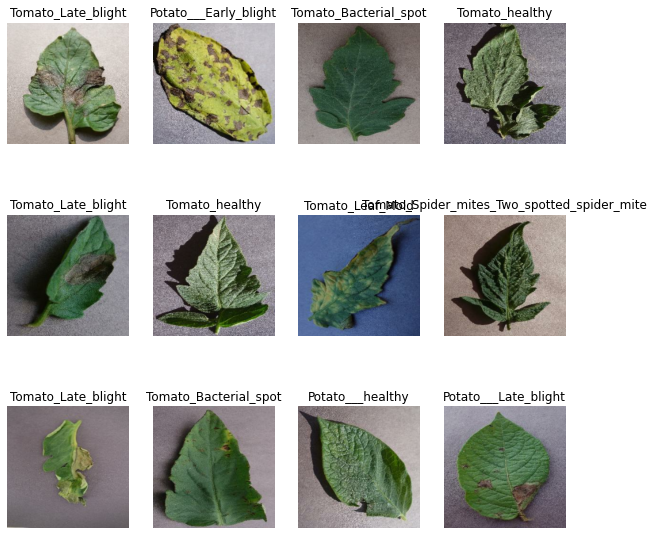

In [5]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [6]:
len(dataset)

323

In [7]:
train_size = 0.75
len(dataset)*train_size

242.25

In [8]:
#remaining saved as temp test to be splitted latter

test_ds = dataset.skip(242)
len(test_ds)

81

In [9]:
val_size=0.15
len(dataset)*val_size

48.449999999999996

In [10]:
val_ds = test_ds.take(48)
len(val_ds)

48

In [11]:
test_ds = test_ds.skip(48)
len(test_ds)

33

In [12]:
def get_dataset_partitions_tf(ds, train_split=0.75, val_split=0.15, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [13]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
#scaling process where the pixel values will be scaled from 0 to 1 instead of 0-255
#preprocessing layer

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
#Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.25),
])

In [17]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 15

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [20]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=30,
)

Epoch 1/30


2022-10-05 16:33:01.356675: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2022-10-05 16:33:02.461088: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


242/242 [==============================] - 75s 282ms/step - loss: 2.2395 - accuracy: 0.2623 - val_loss: 1.8642 - val_accuracy: 0.3984
Epoch 2/30
242/242 [==============================] - 64s 265ms/step - loss: 1.4026 - accuracy: 0.5376 - val_loss: 0.9987 - val_accuracy: 0.6517
Epoch 3/30
242/242 [==============================] - 64s 264ms/step - loss: 0.8686 - accuracy: 0.7014 - val_loss: 1.3749 - val_accuracy: 0.5911
Epoch 4/30
242/242 [==============================] - 65s 270ms/step - loss: 0.6731 - accuracy: 0.7667 - val_loss: 0.7482 - val_accuracy: 0.7428
Epoch 5/30
242/242 [==============================] - 65s 268ms/step - loss: 0.5240 - accuracy: 0.8204 - val_loss: 0.6930 - val_accuracy: 0.7676
Epoch 6/30
242/242 [==============================] - 65s 267ms/step - loss: 0.4907 - accuracy: 0.8271 - val_loss: 0.5700 - val_accuracy: 0.7982
Epoch 7/30
242/242 [==============================] - 65s 269ms/step - loss: 0.4066 - accuracy: 0.8564 - val_loss: 0.5174 - val_accuracy: 0.8

In [22]:
scores = model.evaluate(test_ds)

33/33 [==============================] - 4s 26ms/step - loss: 0.1794 - accuracy: 0.9427


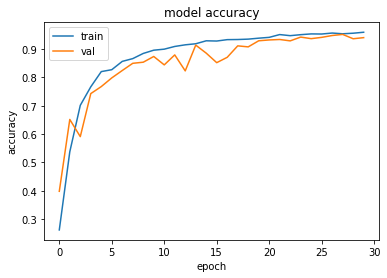

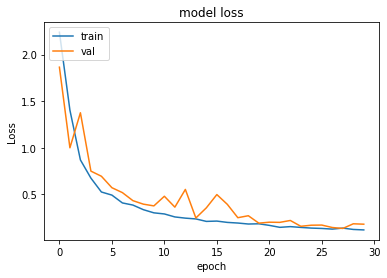

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()












plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

first image to predict
actual label: Tomato_Early_blight
2/2 [==============================] - 0s 6ms/step
predicted label: Tomato_Early_blight


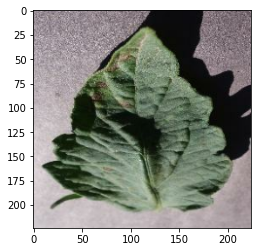

In [24]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [25]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 11ms/step


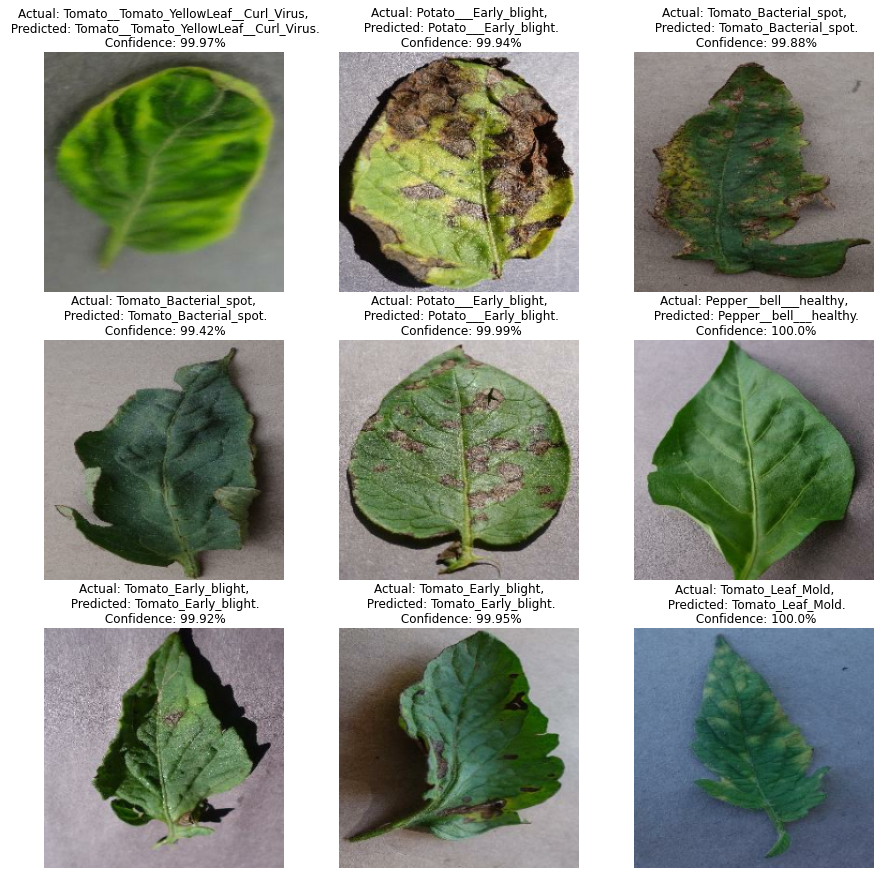

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
!mkdir models
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")